# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [5]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [6]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# # parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
mass        = my_data['STELLAR_MASS'].values[index].astype(float)                  # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [7]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
n_obs   = x1.size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = 5                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['N'] = n_obs

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

### 2.1 Fit: STAN code 

In [9]:
stan_code = """
    data{
        int<lower=0> N;
        int<lower=0> N2;
        int<lower=0> K;
        int Y[N];
        matrix[N,K] X;
        matrix[N2,K] X2;
    }

    parameters{
        vector[K] beta;
    }

    transformed parameters{
        vector[N] eta;
        eta = X * beta;
    }

    model{
        Y ~ bernoulli_logit(eta);
    }

    generated quantities{
        vector[N2] etanew;
        real<lower=0, upper=1.0> pnew[N2];
        etanew = X2 * beta;
        for (j in 1:N2){
            pnew[j] = inv_logit(etanew[j]);
        }
    }
"""

### 2.2 Fit settings (for STAN)

In [10]:
iterations = 15000
chains     = 4                           # HMC chains
warmup     = 5000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [11]:
control = {}
control['max_treedepth'] = 30
control['adapt_delta'] = 0.99

In [12]:
start = time.time()

model = pystan.StanModel(model_code=stan_code)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9aeae9f053f6674eec0d58f69781a4c9 NOW.


--------------------------------------------------
CPU process time: 1.15 [min]
--------------------------------------------------


### 2.3 Running the fit

In [13]:
start = time.time()

fit = model.sampling(data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup, n_jobs=jobs, 
                     control=control)
end = time.time()
print_time(start, end)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 5.89 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [14]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.07 [min]
--------------------------------------------------


In [15]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/Model/entirefit_noemlines.csv', index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 3.13 [min]
--------------------------------------------------


In [16]:
posteriors = fit_df[fit.flatnames[:5]]
header_posteriors = fit.flatnames[:5]

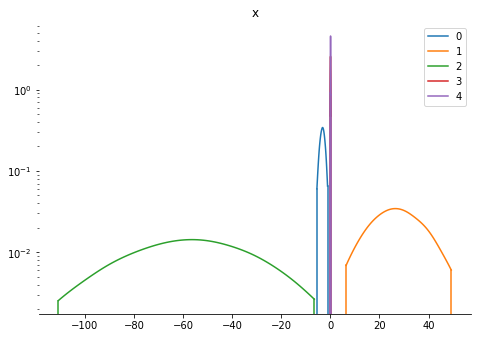

In [17]:
arviz.plot_density(data=[fit['beta[1]'], fit['beta[2]'], fit['beta[3]'], fit['beta[4]'], fit['beta[5]']])
plt.yscale('log')
plt.show()

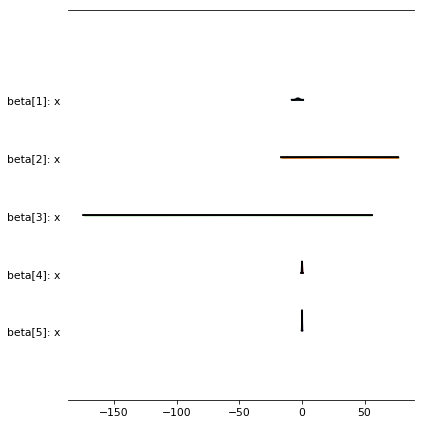

In [18]:
arviz.plot_forest(data=[fit['beta[1]'], fit['beta[2]'], fit['beta[3]'], fit['beta[4]'], fit['beta[5]']], 
                  kind='ridgeplot', model_names=['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'],
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest05.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
figsize=(6,3)

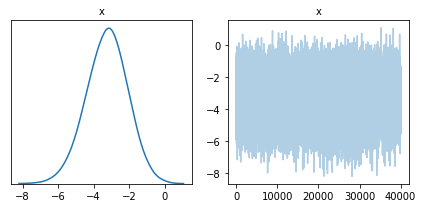

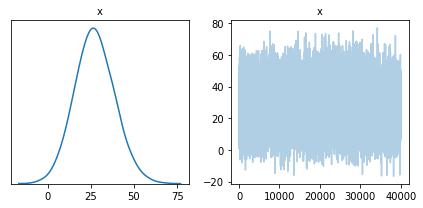

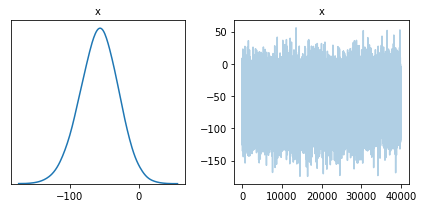

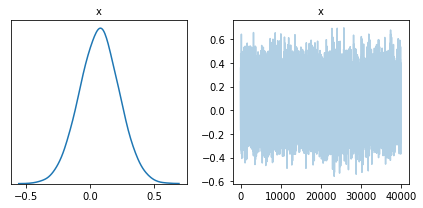

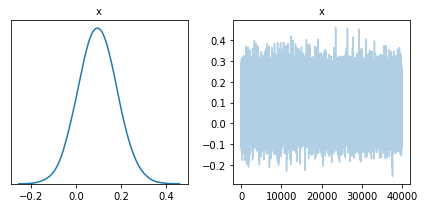

In [20]:
plot = arviz.plot_trace(data=fit['beta[1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5]'], figsize=figsize)
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/trace_class01.pdf', bbox_inches='tight')
plt.show()

### 3.2 Saving the automatic summary from STAN

In [21]:
summary = pystan.stansummary(fit=fit, digits_summary=4)

In [22]:
summary_arr  = np.array(summary.split('\n'))
summary_clean = summary_arr[5:-6,]

In [23]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [24]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp = recovered_pars

In [25]:
rp

array([[ 0.06794   ,  9.729482  ],
       [ 0.07760759,  9.729482  ],
       [ 0.08727517,  9.729482  ],
       ...,
       [ 0.32896483, 11.67857   ],
       [ 0.33863241, 11.67857   ],
       [ 0.3483    , 11.67857   ]])

#### 3.2.2 Checking if the numbers aren't overlaped

In [26]:
new_summary = list(np.zeros(len(header_fit)))
for i in range(summary_clean.size):
    if len(summary_clean[i].split())!=11:   # the length of the list must be 11, in which case we connect them directly
        new_summ_temp = np.array(summary_clean[i].split())
        new_summ_temp = np.concatenate((new_summ_temp, ['X']))
        new_summary   = np.vstack((new_summary, new_summ_temp))
#         new_summary   = np.vstack((new_summary, np.concatenate((new_summ_temp, ['X']))))
        print ('new_summary[%d] = ' %i, "'%s'," %summary_clean[i])
    else:
        new_summ_temp = np.array(summary_clean[i].split()).reshape(1,11)
        new_summary   = np.vstack((new_summary, new_summ_temp))
new_summary = new_summary[1:,:]            # removing the zeroes in the beggining
print (new_summary[:,0].shape)

new_summary[2] =  'beta[3]     -57.93  0.3027 27.719-1.14e2 -76.08 -57.35 -39.25 -4.616   8386 1.0002',
new_summary[526] =  'etanew[18]  0.6211   0.009 0.9264 -1.191-9.429e-6 0.6171 1.2405 2.4503  10634 1.0001',
(2309,)


In [27]:
new_summary[2] =  ['beta[3]', '-57.93', '0.3027', '27.719', '-1.14e2', '-76.08', '-57.35', '-39.25', '-4.616', '8386',
                   '1.0002']
new_summary[526] =  ['etanew[18]', '0.6211', '0.009', '0.9264', '-1.191', '-9.429e-6', '0.6171', '1.2405', '2.4503',
                     '10634', '1.0001']

#### 3.2.3 Retrieving only the probabilities from the summary and stacking x1 and x2 at the end of the dataframe

In [28]:
new_summary

array([['beta[1]', '-3.257', '0.013', ..., '-1.049', '7950', '1.0001'],
       ['beta[2]', '27.341', '0.129', ..., '50.818', '7984', '1.0002'],
       ['beta[3]', '-57.93', '0.3027', ..., '-4.616', '8386', '1.0002'],
       ...,
       ['pnew[898]', '0.5815', '0.0009', ..., '0.8203', '24018', '1.0'],
       ['pnew[899]', '0.5563', '0.0009', ..., '0.8122', '23033', '1.0'],
       ['pnew[900]', '0.5286', '0.001', ..., '0.8039', '21467', '1.0']],
      dtype='<U32')

In [29]:
tosave = np.column_stack([new_summary[1409:, :], rp])

In [30]:
probs = pd.DataFrame(tosave)

In [31]:
model_results_df = pd.DataFrame(tosave)
model_results_df.columns = header_fit + ['Z', 'LOG_STELLAR_MASS']
model_results_df.to_csv('../../LargeFilesResults/Model/fit_summ_noemlines.csv', header=True, index=False)

In [32]:
model_results_df

parameter    mean se_mean      sd    2.5%     25%     50%     75%  \
0      pnew[1]   0.282  0.0008  0.1182  0.0949  0.1942  0.2679  0.3558   
1      pnew[2]  0.3181  0.0009  0.1278  0.1089   0.223  0.3047  0.4001   
2      pnew[3]   0.354   0.001  0.1373  0.1229  0.2519  0.3422  0.4452   
3      pnew[4]  0.3891  0.0012  0.1463  0.1362    0.28  0.3791  0.4888   
4      pnew[5]  0.4224  0.0013  0.1544  0.1482  0.3072  0.4149  0.5299   
5      pnew[6]  0.4537  0.0014  0.1615  0.1597  0.3333  0.4487  0.5687   
6      pnew[7]  0.4824  0.0015  0.1674  0.1708  0.3583  0.4808  0.6043   
7      pnew[8]  0.5084  0.0016  0.1723  0.1801  0.3811  0.5105  0.6369   
8      pnew[9]  0.5317  0.0017  0.1761    0.19  0.4028  0.5367  0.6652   
9     pnew[10]  0.5522  0.0017   0.179  0.1982   0.422  0.5605  0.6892   
10    pnew[11]  0.5701  0.0017  0.1812  0.2058   0.439  0.5809  0.7098   
11    pnew[12]  0.5853  0.0018  0.1828  0.2131  0.4543  0.5988  0.7272   
12    pnew[13]  0.5981  0.0018  0.1839  0.2189  0.4674  0.6137  0.7419   
13    pnew[14]  0.6086  0.0018  0.1847  0.2244  0.4785  0.6259  0.7536   
14    pnew[15]  0.6168  0.0018  0.1852  0.2285  0.4874  0.6353  0.7627   
15    pnew[16]  0.6228  0.0018  0.1855  0.2308  0.4938  0.6425  0.7694   
16    pnew[17]  0.6267  0.0018  0.1858  0.2325  0.4981  0.6472  0.7738   
17    pnew[18]  0.6285  0.0018   0.186   0.233     0.5  0.6495  0.7757   
18    pnew[19]  0.6282  0.0018  0.1862  0.2323  0.4994  0.6497  0.7753   
19    pnew[20]  0.6258  0.0017  0.1865  0.2297  0.4971   0.647  0.7729   
20    pnew[21]  0.6213  0.0017   0.187  0.2264  0.4916  0.6421   0.769   
21    pnew[22]  0.6147  0.0017  0.1876  0.2214  0.4834  0.6345  0.7625   
22    pnew[23]  0.6058  0.0017  0.1883  0.2147  0.4728  0.6237  0.7543   
23    pnew[24]  0.5946  0.0016  0.1893  0.2059  0.4591  0.6112  0.7435   
24    pnew[25]   0.581  0.0016  0.1905  0.1961  0.4436  0.5956  0.7308   
25    pnew[26]   0.565  0.0015   0.192  0.1843  0.4254  0.5763  0.7149   
26    pnew[27]  0.5466  0.0015  0.1937  0.1709  0.4037  0.5549   0.697   
27    pnew[28]  0.5258  0.0014  0.1957  0.1558  0.3791  0.5311  0.6769   
28    pnew[29]  0.5027  0.0014  0.1978  0.1393  0.3514   0.504  0.6543   
29    pnew[30]  0.4774  0.0013  0.2001  0.1214  0.3229  0.4737   0.629   
..         ...     ...     ...     ...     ...     ...     ...     ...   
870  pnew[871]  0.3387  0.0013  0.1725  0.0746  0.2046  0.3159  0.4533   
871  pnew[872]  0.3738  0.0013  0.1736   0.094  0.2392  0.3564  0.4928   
872  pnew[873]  0.4086  0.0013  0.1739  0.1146  0.2759  0.3958  0.5314   
873  pnew[874]  0.4427  0.0012  0.1732  0.1367  0.3119  0.4343  0.5669   
874  pnew[875]  0.4752  0.0012  0.1718  0.1603  0.3469  0.4717  0.6002   
875  pnew[876]  0.5059  0.0012  0.1697  0.1856  0.3802  0.5067  0.6314   
876  pnew[877]  0.5344  0.0012  0.1672  0.2102  0.4124  0.5386  0.6588   
877  pnew[878]  0.5604  0.0012  0.1642  0.2343  0.4425  0.5676  0.6836   
878  pnew[879]  0.5839  0.0012   0.161  0.2574  0.4704   0.594  0.7056   
879  pnew[880]  0.6048  0.0012  0.1576    0.28  0.4956  0.6165  0.7242   
880  pnew[881]  0.6231  0.0011  0.1542  0.3001  0.5176  0.6361  0.7398   
881  pnew[882]  0.6389  0.0011  0.1507  0.3187  0.5374  0.6534   0.753   
882  pnew[883]  0.6523  0.0011  0.1472  0.3365  0.5542  0.6674  0.7636   
883  pnew[884]  0.6634  0.0011  0.1438  0.3519  0.5686   0.679  0.7722   
884  pnew[885]  0.6723  0.0011  0.1405  0.3667  0.5805  0.6877  0.7785   
885  pnew[886]  0.6789  0.0011  0.1373  0.3791  0.5897  0.6944  0.7825   
886  pnew[887]  0.6835   0.001  0.1343    0.39  0.5966  0.6986  0.7847   
887  pnew[888]  0.6859   0.001  0.1315  0.3977  0.6012  0.7004  0.7849   
888  pnew[889]  0.6863   0.001   0.129  0.4037  0.6037  0.7003  0.7832   
889  pnew[890]  0.6845   0.001  0.1267  0.4072  0.6033  0.6978  0.7794   
890  pnew[891]  0.6805  0.0009  0.1248  0.4087  0.6004  0.6931  0.7735   
891  pnew[892]  0.6742  0.0009  0.1234  0.4069  0.5943  0.6863  0.7658   
892  pnew

In [33]:
posteriors = fit_df[fit.flatnames[:5]]

In [34]:
fit_df.keys()

Index(['chain', 'draw', 'warmup', 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]',
       'beta[5]', 'eta[1]', 'eta[2]',
       ...
       'pnew[898]', 'pnew[899]', 'pnew[900]', 'lp__', 'accept_stat__',
       'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object', length=2319)

In [35]:
fit_df['treedepth__'].describe()

count    40000.000000
mean         7.099075
std          1.226987
min          1.000000
25%          6.000000
50%          8.000000
75%          8.000000
max          9.000000
Name: treedepth__, dtype: float64

In [36]:
fit_df['n_leapfrog__'].describe()

count    40000.000000
mean       238.333850
std        140.578662
min          1.000000
25%        127.000000
50%        255.000000
75%        255.000000
max        767.000000
Name: n_leapfrog__, dtype: float64

In [37]:
posteriors.to_csv('../../LargeFilesResults/Model/posteriors_noemlines.csv', index=False)

In [38]:
posteriors

beta[1]    beta[2]    beta[3]   beta[4]   beta[5]
0     -3.685708  32.610873 -68.358126 -0.039401 -0.028859
1     -3.679616  30.225845 -60.233817 -0.089985  0.062002
2     -3.479198  30.017847 -63.905318 -0.093453  0.063950
3     -4.063318  29.893671 -49.725777 -0.111552  0.100827
4     -2.742927  24.280441 -56.647008  0.046149  0.064127
5     -2.754137  24.960116 -54.459282  0.047867  0.063602
6     -2.980657  22.040077 -36.420121  0.044529  0.098178
7     -2.091041  10.732868  -7.811155 -0.064943  0.002874
8     -1.445604   9.527786 -15.685227 -0.018466  0.020789
9     -1.600843  15.171928 -33.574333  0.154544 -0.062451
10    -1.842484  14.758914 -35.427240  0.198744 -0.074319
11    -1.746121  16.344342 -34.312536  0.220827 -0.076968
12    -2.278339  19.762723 -46.142843  0.335572 -0.065030
13    -2.358164  22.818458 -57.090280  0.366247 -0.001856
14    -4.855066  40.683619 -83.731632 -0.274025  0.193970
15    -3.621260  31.750933 -67.829557 -0.105850  0.110387
16    -3.728301  29.811549 -57.608161 -0.071376  0.129745
17    -3.121596  26.603480 -59.109210  0.228994  0.084520
18    -3.451941  27.815062 -58.932890  0.244801  0.078561
19    -4.031208  34.135134 -74.421660  0.098801  0.116263
20    -2.513417  17.004687 -26.946873 -0.009745  0.088655
21    -1.981562  13.808771 -26.041375  0.068690  0.033454
22    -2.726972  19.093987 -33.826352  0.083630  0.070158
23    -2.089302  17.890107 -37.711372  0.129012  0.064073
24    -2.233311  16.594033 -39.959005  0.142372  0.061857
25    -3.661353  31.610269 -62.254760 -0.179442  0.085796
26    -2.613876  21.925219 -39.512279 -0.132784 -0.049750
27    -2.845939  20.977328 -34.181888 -0.165012 -0.088066
28    -2.874184  20.925659 -31.796833 -0.150317 -0.086287
29    -3.442750  32.949312 -83.732052  0.347122  0.232256
...         ...        ...        ...       ...       ...
39970 -3.588044  30.255973 -65.666638  0.230324  0.150500
39971 -3.309193  29.061320 -67.756525  0.192893  0.159159
39972 -4.388649  39.052764 -83.133206 -0.045364  0.086622
39973 -4.025133  33.070983 -70.557949 -0.064522  0.199801
39974 -3.585790  33.822481 -82.098562  0.296314  0.180954
39975 -4.070044  33.262100 -64.762441 -0.089981  0.102232
39976 -2.666686  20.981067 -47.311520  0.248846  0.094319
39977 -2.017298  17.985052 -48.289182  0.264644  0.142133
39978 -2.050563  17.308442 -41.475618  0.299917  0.139575
39979 -2.718453  26.512209 -66.761265  0.206098  0.029334
39980 -2.649893  25.769693 -63.690856  0.210869  0.032356
39981 -2.866559  24.249181 -48.899736 -0.058050  0.011399
39982 -5.231857  44.714455 -93.110486 -0.110480  0.167385
39983 -3.375593  30.787870 -71.572389  0.133736  0.067944
39984 -2.925753  19.628016 -29.013179 -0.077271  0.126759
39985 -2.616764  20.596061 -39.065243  0.143697  0.195078
39986 -3.090850  27.245472 -59.126069  0.182144  0.232015
39987 -3.112943  26.617974 -59.356280  0.178788  0.230633
39988 -3.405610  25.840734 -53.942547  0.248525  0.224956
39989 -3.385902  26.024003 -52.882819  0.242654  0.222642
39990 -3.157055  25.844454 -57.980966  0.196428  0.224350
39991 -4.120108  33.295318 -67.327757 -0.049723  0.147095
39992 -4.303661  39.113802 -88.579126  0.035094  0.151678
39993 -3.930737  35.670427 -79.794480  0.022393  0.087481
39994 -3.522984  29.878565 -62.410339 -0.062722  0.111100
39995 -3.803785  31.678070 -64.263827  0.032643  0.077854
39996 -1.811527  16.110379 -40.640781  0.366430  0.123558
39997 -1.818247  15.772861 -41.602050  0.358179  0.122348
39998 -3.629019  31.157302 -69.699928  0.145169  0.134125
39999 -3.424142  26.927712 -51.281300 -0.113373  0.092864

[40000 rows x 5 columns]

In [39]:
diagnostics = pystan.check_hmc_diagnostics(fit, per_chain=True)

In [40]:
diagnostics

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [41]:
model_results_df['Rhat'].max()

'1.0002'

In [42]:
model_results_df['Rhat'].min()

'0.9999'